Build Our Mini Tokenizer Here

In [ ]:
class Word2Sequence:
    PAD_TAG = "<PAD>" # Padding Token
    SOS_TAG = "<SOS>" # Start Of Sentence Token
    EOS_TAG = "<EOS>" # End Of Sentence Token
    UNK_TAG = "<UNK>" # Known Token

    PAD = 0
    SOS = 1
    EOS = 2
    UNK = 3
    
    special_tokens = [PAD_TAG, SOS_TAG, EOS_TAG, UNK_TAG]
        
    def __init__(self, custom_dict = None):
        self.dict = {
            self.PAD_TAG : self.PAD,
            self.SOS_TAG : self.SOS,
            self.EOS_TAG : self.EOS,
            self.UNK_TAG : self.UNK
        } if custom_dict == None else custom_dict
        
        self.count = {}

    def fit(self, sentence):
        """save words in sentence to self.dict
        param: sentence (1D List): [word1, word2, word3...]
        """
        for word in sentence:
            self.count[word] = self.count.get(word, 0) + 1

    def build_vocab(self, min=5, max=None, max_features=None):
        """
        build self.dict and reverse_dict
        param min:          least occurrance of word to be considered
        param max:          max occurrance of word to be considered
        param max_features: max vocab size for tokenizer
        returns:            
        """
        # Delete words in count whose word frequency is less than min
        if min is not None:
            self.count = {word: value for word,value in self.count.items() if value > min}
        # Delete the value with the number of times greater than max
        if max is not None:
            self.count = {word: value for word,value in self.count.items if value < max}
        # Limit the number of reserved words
        if max_features is not None:
            temp = sorted(self.count.items(), key=lambda x:x[-1], reverse=True)[:max_features]
            self.count = dict(temp)

        for word in self.count:
            if word not in self.special_tokens:
                self.dict[word] = len(self.dict)
        
        # reversed self.dict
        self.reverse_dict = dict(zip(self.dict.values(), self.dict.keys()))
    
    def transform(self, sentence, max_len=None, pad_first=False):
        """
        convert setence to int sequence
        param sentence: [word1, word2, word3 ...]
        param max_len: int, do padding or truncation
        returns: 1D List of integers
        """
        if max_len is not None: # do padding here
            if pad_first == False:
                if max_len > len(sentence):
                    sentence = sentence + [self.PAD_TAG] * (max_len-len(sentence))
                if max_len < len(sentence):
                    sentence = sentence[:max_len] #truncation
            else:
                if max_len > len(sentence):
                    sentence = [self.PAD_TAG] * (max_len-len(sentence)) + sentence
                if max_len < len(sentence):
                    sentence = sentence[-max_len:] #truncation

        return [self.dict.get(word, self.UNK) for word in sentence]
    
    def inverse_transform(self, indices, is_tensor=False):
        """
        convert int sequences to string words
        param indices: [1, 2, 3, ...]
        returns: [word1, word2, word3...]
        """
        if is_tensor == False:
            # If the 1D array is PyTorch Tensor do this:
            return [self.reverse_dict.get(idx) for idx in indices]
        
        else:
            
            return [self.reverse_dict.get(idx.item()) for idx in indices]

    def __len__(self):
        return (len(self.dict))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import torch.nn as nn
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Download dataset here: https://drive.google.com/file/d/12qHUwxEFDONbk-ochQOYfbsZV6W2LsE7/view?usp=sharing

In [ ]:
# read small_en-cn.txt file
data_path = '/content/drive/MyDrive/NLP Curriculum/eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist()#english sentences
target_texts = df.chinese.values.tolist()#chinese sentences

In [ ]:
tk = WordPunctTokenizer()
# limit = 100 # IF model computation is still a burden
# english = [tk.tokenize(sentence.lower()) for sentence in input_texts][:limit]
# chinese = [[x for x in sentence] for sentence in target_texts][:limit]
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]

In [ ]:
# calculate max_len
max_en_leng = max([len(seq) for seq in english])
# calculate max_len
max_cn_leng = max([len(seq) for seq in chinese])
print(max_en_leng)
print(max_cn_leng)

25
39


1. Since the Max Occurence of English words is 7, input maxlen will be 8
2. Since the Max Occurence of Chinese characters is 9, input maxlen will be 10

In [ ]:
# WHY? Data Structure:
# 1. Encoder Input: [word1, word2, ... + <EOS>]
# 2. Decoder Input: [<SOS> + word1, word2, ...]
# 3. Decoder Output:[word1, word2, ... + <EOS>]

In [ ]:
inp_tk = Word2Sequence()
for words in english:
    inp_tk.fit(words)
inp_tk.build_vocab(min=1, max_features=None)

oup_tk = Word2Sequence()
for words in chinese:
    oup_tk.fit(words)
oup_tk.build_vocab(min=1, max_features=None)

print(f"Total English Words in our input tokenizer: {len(inp_tk.dict)}")
print(f"Total Chinese chars in our output tokenizer: {len(oup_tk.dict)}")

Total English Words in our input tokenizer: 199
Total Chinese chars in our output tokenizer: 317


In [ ]:
class Dataset(Dataset):
  def __init__(self, X, Y, in_tknz, out_tknz, in_maxlen, out_maxlen):
    self.in_maxlen = in_maxlen
    self.out_maxlen = out_maxlen
    
    self.X = X # english sentences
    self.Y = Y # chinese sentences
    
    self.in_tknz = in_tknz # input tokenizer for english
    self.out_tknz = out_tknz # output tokenizer for chinese
  
  def __getitem__(self, idx):
    # -1 because we stil have to concate the <SOS> and <EOS> tokens
    enc_in = self.X[idx][:self.in_maxlen-1]
    enc_in = enc_in + ["<EOS>"]
    
    dec_in = self.Y[idx][:self.out_maxlen-1]
    dec_in = ["<SOS>"] + dec_in
    
    dec_out = self.Y[idx][:self.out_maxlen-1]
    dec_out = dec_out + ["<EOS>"]
    
    # Convert enc_in, dec_in, dec_out to 1D integers
    enc_in = self.in_tknz.transform(enc_in, max_len=self.in_maxlen, pad_first=False)
    dec_in = self.out_tknz.transform(dec_in, max_len=self.out_maxlen, pad_first=False)
    dec_out = self.out_tknz.transform(dec_out, max_len=self.out_maxlen, pad_first=False)

    return enc_in, dec_in, dec_out

  def __len__(self):
    # Returns number of data in this dataset
    return len(self.X)

# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
#       we can convert data into Long Tensors Here
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_in, dec_out]， [enc_in, dec_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader

In [ ]:
# NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 
# 1. <SOS>, word1, word2, word3, ..., <EOS>
# 2. word1, word2, word3, ..., <EOS> 
# 3. word1, word2, word3, ...

# NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):
# Decoder Input: <SOS>, word1, word2, word3, ...
# Decoder Output: word1, word2, word3, ..., <EOS> 

In [ ]:
eng_maxlen = 26 # 25 + 1(<EOS> token)
chin_maxlen = 40 # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1 # Seq2Seq is very ram consuming, we have to keep batch_size low

# Get PyTorch Dataset
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = inp_tk, out_tknz = oup_tk,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)

In [ ]:
# Seq2Seq Paarameters
in_maxlen = 26 # 25 + 1(<EOS> token)
out_maxlen = 40 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 32 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(inp_tk.dict) # OR... vocab size of englisth -> 199
dec_n_class = len(oup_tk.dict) # OR... vocab size of chinese -> 317
batch_size = 1

Seq2Seq is really a CLASSIFICATION problem, with num classes of output vocab size to predict

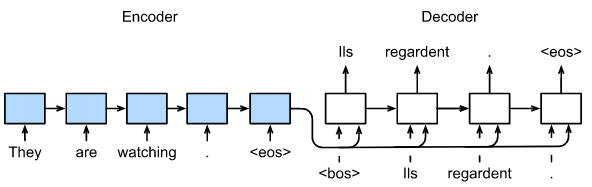

"d_model" is just a transformer term for number of embeddings per word token

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(
        self, in_maxlen, out_maxlen, n_hidden, enc_n_class, dec_n_class, d_model, num_layers
    ):
        super(Seq2Seq, self).__init__()
        self.in_maxlen = in_maxlen # 26
        self.out_maxlen = out_maxlen # 40
        self.n_hidden = n_hidden # 32
        self.enc_n_class = enc_n_class # 199
        self.dec_n_class = dec_n_class # 317
        self.d_model = d_model # 64
        self.num_layers = num_layers # 1
        
        self.encoder = nn.GRU(
            input_size = self.d_model,
            hidden_size = self.n_hidden,
            num_layers = self.num_layers,
            dropout = 0.3
        )
        self.decoder = nn.GRU(
            input_size = self.d_model,
            hidden_size = self.n_hidden,
            num_layers = self.num_layers,
            dropout = 0.3
        )
        self.embed_enc = nn.Embedding(
            num_embeddings = self.enc_n_class,
            embedding_dim = self.d_model
        )
        self.embed_dec = nn.Embedding(
            num_embeddings = self.dec_n_class,
            embedding_dim = self.d_model
        )
        
        self.fc = nn.Linear(self.n_hidden, self.dec_n_class)
    
    def forward(self, enc_input, enc_hidden, dec_input):
        # embedded_X:[1(b), 26(in_maxlen), 64(d_model)] <- enc_input: [1(b), 26(in_maxlen)]
        embedded_X = self.embed_enc(enc_input)
        
        # embedded_X: [26(in_maxlen), 1(b), 64(d_model)] <- [1(b), 26(in_maxlen), 64(d_model)]
        embedded_X = embedded_X.permute(1, 0, 2)
        
        # For GRU -> h_t.shape: [1(num_layers), 1(b), 32(hidden_size)]
        _, h_t = self.encoder(embedded_X, enc_hidden)
        
        # embedded_Y:[1(b), 40(out_maxlen), 64(d_model)] <- dec_input: [1(b), 40(out_maxlen)]
        embedded_Y = self.embed_dec(dec_input)
        
        # embedded_Y: [40(in_maxlen), 1(b), 64(d_model)] <- [1(b), 40(out_maxlen), 64(d_model)]
        embedded_Y = embedded_Y.permute(1, 0, 2)
        outputs, _ = self.decoder(embedded_Y, h_t)
        
        # outputs: [1(b), 40(out_maxlen), 64(d_model)] <- [40(in_maxlen), 1(b), 64(d_model)]
        outputs = outputs.permute(1, 0, 2)
        
        # [1(b), 40(out_maxlen), 317(dec_n_class/output vocab_size)] <- [1(b), 40(out_maxlen), 64(d_model)]
        out = self.fc(outputs) 
        return out
    
    def init_enc_hidden_GRU(self, batch_size, device):
        # [1(num_layers), 1(batch_size), 32(hidden_size)]
        return torch.zeros(self.num_layers, batch_size, self.n_hidden).to(device)

In [ ]:
model = Seq2Seq(
    in_maxlen = in_maxlen,
    out_maxlen = out_maxlen,
    n_hidden = n_hidden,
    enc_n_class = len(inp_tk.dict),
    dec_n_class = len(oup_tk.dict),
    d_model = d_model,
    num_layers = 1,
)
model.to(device)
# # If you have saved a model before
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Seq2Seq(
  (encoder): GRU(64, 32, dropout=0.3)
  (decoder): GRU(64, 32, dropout=0.3)
  (embed_enc): Embedding(199, 64)
  (embed_dec): Embedding(317, 64)
  (fc): Linear(in_features=32, out_features=317, bias=True)
)

In [ ]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

Training!!!

In [ ]:
epochs = 800
torch.cuda.empty_cache()
model.train()
model.to(device)
loss_records = []
for epoch in range(epochs):
    loss = 0
    for _, (enc_in, dec_in, dec_out) in enumerate(dataloader):
        # enc_h_0.shape: [1(num_layers), 1(batch_size), 32(hidden_size)]
        enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
        # To Cuda Device if available
        enc_in, dec_in = enc_in.to(device), dec_in.to(device)
        
        pred = model(enc_in, enc_h_0, dec_in)
        
        dec_out = dec_out.to(device)
        for i in range(len(dec_out)): # dec_in.shape: [1(b), 40(out_maxlen)]
            # pred[i].shape: [40(out_maxlen), 317(dec_n_class)]
            # dec_out[i].shape: [40(out_maxlen)]
            loss += criterion(pred[i], dec_out[i])

    if (epoch) % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

    if (epoch) % 100 == 0:
        loss_records.append(loss)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    torch.save(model.state_dict(), "seq2seq.pt")

Epoch: 0, Loss: 581.9937744140625
Epoch: 10, Loss: 276.70343017578125
Epoch: 20, Loss: 235.17352294921875
Epoch: 30, Loss: 213.75086975097656
Epoch: 40, Loss: 191.01071166992188
Epoch: 50, Loss: 168.15455627441406
Epoch: 60, Loss: 146.25950622558594
Epoch: 70, Loss: 126.3169937133789
Epoch: 80, Loss: 108.5972900390625
Epoch: 90, Loss: 92.79605102539062
Epoch: 100, Loss: 78.60147094726562
Epoch: 110, Loss: 66.14045715332031
Epoch: 120, Loss: 55.424957275390625
Epoch: 130, Loss: 46.42070388793945
Epoch: 140, Loss: 38.86812210083008
Epoch: 150, Loss: 32.55308532714844
Epoch: 160, Loss: 27.45504379272461
Epoch: 170, Loss: 23.296125411987305
Epoch: 180, Loss: 19.993335723876953
Epoch: 190, Loss: 17.395219802856445
Epoch: 200, Loss: 15.101462364196777
Epoch: 210, Loss: 13.281706809997559
Epoch: 220, Loss: 12.044764518737793
Epoch: 230, Loss: 10.657811164855957
Epoch: 240, Loss: 9.922093391418457
Epoch: 250, Loss: 8.850767135620117
Epoch: 260, Loss: 7.83745002746582
Epoch: 270, Loss: 7.051308

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).


<Figure size 432x288 with 0 Axes>

Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3196 ticks ([-27.8, ..., 611.2]),

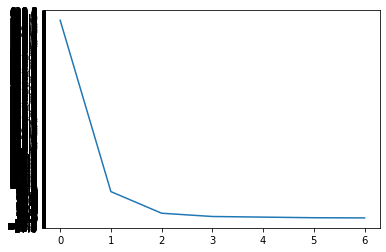

In [ ]:
showPlot([loss.cpu().item() for loss in loss_records])

In [ ]:
def translate(eng_sent, model, device):
    model.eval()
    model.to(device)
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = inp_tk.transform(eng_sent, max_len=in_maxlen, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*out_maxlen)[:out_maxlen]
    dec_in = oup_tk.transform(dec_in, max_len=out_maxlen, pad_first=False)
    
    enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)

    eng_sent = eng_sent.unsqueeze(0)
    dec_in = dec_in.unsqueeze(0)
    eng_sent, dec_in = eng_sent.to(device), dec_in.to(device)

    with torch.no_grad():
        # eng_sent: [1(b), 26(in_maxlen)]
        embedded_X = model.embed_enc(eng_sent)
        # embedded_X: [26(in_maxlen), 1(b), 64(d_model)] <- [1(b), 26(in_maxlen), 64(d_model)]
        embedded_X = embedded_X.permute(1, 0, 2)
        _, memory = model.encoder(embedded_X, enc_h_0)
        pred_loc = 0
        for i in range(out_maxlen-1):
            embedded_Y = model.embed_dec(dec_in)
            embedded_Y = embedded_Y.permute(1, 0, 2)
            outputs, _ = model.decoder(embedded_Y, memory)
            outputs = outputs.permute(1, 0, 2)
            pred = model.fc(outputs)
            pred = pred[0][pred_loc].topk(1)[1].item()
            pred_loc += 1
            if pred == 2:
                dec_in[0][pred_loc] = pred
                break
            else:
                dec_in[0][pred_loc] = pred
    return dec_in

This illustrates that our model works Hurray! However, the model only works within the scope of training sets. So... Let's try Seq2Seq + Attention in the next episode

In [ ]:
import random
eng_sents = random.sample(input_texts, 5)
for sent in eng_sents:
  translated = translate(sent, model, torch.device("cpu"))
  translated_sent = oup_tk.inverse_transform(translated[0], is_tensor=True)
  translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
  print(f"{sent} -> \n{translated_sent}")

It's hard to believe that Tom wasn't aware that Mary was in love with him. -> 
真难相信汤姆不知道玛丽爱他。
I learned to drive a car and got a driver's license when I was eighteen. -> 
我十八歲時，學了開車、考到了駕照。
Tom came to the conclusion that no matter what he did, Mary wouldn't like it. -> 
汤姆得出<UNK>论他做什么，玛丽都不会喜欢的结论。
Tom was able to make himself understood in French when he visited Paris. -> 
在<UNK><UNK>，沒有人能<UNK>理解湯姆的法文。
She visits the dentist on a regular basis, so she seldom gets toothaches. -> 
她定<UNK>去看牙<UNK>，所以她很少牙<UNK>。
